## Automated Detection of Abusive Comments
#### CS 690N Advanced NLP - Final Project
Anmol Singh Suag {asuag@umass.edu}

1. Download FastText 300 D from https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki-news-300d-1M.vec.zip and save in the same folder
2. Download Glove 6B 5D from http://nlp.stanford.edu/data/glove.6B.zip and save in same file
3. The notebook takes about 1 hour 30 mins to train
4. The results have been precomputed and can be viewed in nbviewer

In [295]:
#Importing all required libs for the project
#Python 3.6

import sys, os, re, csv, codecs
import numpy as np
import pandas as pd
import enchant
import random
import itertools
import operator

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation,GRU,Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D,GlobalMaxPooling1D,GlobalAveragePooling1D, concatenate, SpatialDropout1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

import seaborn as sns
color = sns.color_palette()
sns.set_style("whitegrid")
from wordcloud import WordCloud ,STOPWORDS
from tqdm import tqdm

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.palettes import Spectral6
output_notebook()

%matplotlib inline

import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

Loading BokehJS ...

### Section 1 : Data Preparation

1. Data files reside inside the same folder as the Jupyter Notebook
2. Dataset is a join of Wikipedia Detox comment dataset[1] (Wulcyzn et al. 2017)[2] (augmented labels version from Kaggle) and Twitter Dataset[3] (Davidson et al. 2017)[4]


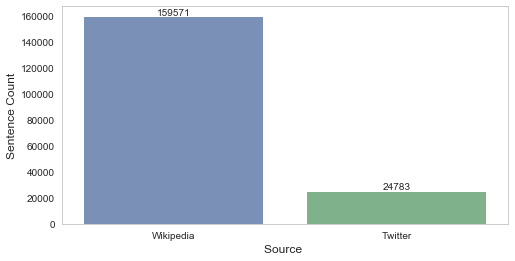

In [2]:
#Importing data
wikipedia_data = pd.read_csv("wikipedia-detox.csv")
twitter_data = pd.read_csv("twitter-davidson.csv")


plt.figure(figsize=(8,4))
ax= sns.barplot(["Wikipedia","Twitter"], [len(wikipedia_data),len(twitter_data)], alpha=0.8)
plt.ylabel('Sentence Count', fontsize=12)
plt.xlabel('Source ', fontsize=12)
rects = ax.patches
labels = [len(wikipedia_data),len(twitter_data)]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
ax.grid(False)
plt.show()

#Wikipedia Dataset has 159571 Crowdflower annotated comments
#Twitter dataset has 24783 Crowdflower annotated tweets

In [3]:
dataset = pd.DataFrame(columns=['sentence','toxic','insult','hate','threat','obscene','neutral'])
sen_list=[]
toxic_list=[]
insult_list=[]
hate_list=[]
threat_list=[]
obscene_list=[]
neutral_list=[]

In [4]:
for index, row in tqdm(wikipedia_data.iterrows()):
    sentence = str(row['comment_text'])
    toxic =0
    if(row['toxic']==1 or row['severe_toxic']==1):
        toxic=1
    insult=row['insult']
    hate=row['identity_hate']
    threat=row['threat']
    obscene=row['obscene']
    neutral=0
    if((toxic+insult+hate+threat+obscene)==0):
        neutral=1
    
    sen_list.append(sentence)
    toxic_list.append(toxic)
    insult_list.append(insult)
    hate_list.append(hate)
    threat_list.append(threat)
    obscene_list.append(obscene)
    neutral_list.append(neutral)    

159571it [00:41, 3846.53it/s]


In [5]:
for index, row in tqdm(twitter_data.iterrows()):
    sentence = str(row['tweet'])
    toxic =0
    insult=0
    hate=0
    threat=0
    obscene=0
    neutral=0
    if(row['class']==0):
        hate=1
    if(row['class']==1):
        toxic=1
    if(row['class']==2):
        neutral=1
    
    sen_list.append(sentence)
    toxic_list.append(toxic)
    insult_list.append(insult)
    hate_list.append(hate)
    threat_list.append(threat)
    obscene_list.append(obscene)
    neutral_list.append(neutral)

24783it [00:07, 3326.33it/s]


In [6]:
dataset["sentence"]=pd.Series(sen_list).values
dataset["toxic"]=pd.Series(toxic_list).values
dataset["insult"]=pd.Series(insult_list).values
dataset["hate"]=pd.Series(hate_list).values
dataset["threat"]=pd.Series(threat_list).values
dataset["obscene"]=pd.Series(obscene_list).values
dataset["neutral"]=pd.Series(neutral_list).values

In [7]:
dataset.sample(5)

,sentence,toxic,insult,hate,threat,obscene,neutral
89831,"""\n\nThis article is horrible... this page is ...",0,0,0,0,0,1
145176,Like I said - cunt.,1,0,0,0,1,0
38629,"Sorry, it was Polly who slapped the old woman ...",0,0,0,0,0,1
13183,What Disruptive Edits? The article as it curre...,0,0,0,0,0,1
184204,ugly hoe,1,0,0,0,0,0


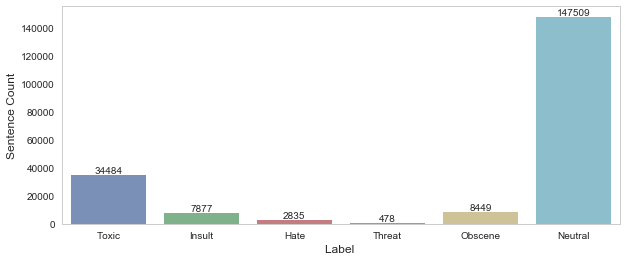

In [8]:
plt.figure(figsize=(10,4))
counts=dataset.iloc[:,1:].sum()
ax= sns.barplot(["Toxic","Insult","Hate","Threat","Obscene","Neutral"], [counts["toxic"],counts["insult"],counts["hate"],counts["threat"],counts["obscene"],counts["neutral"]], alpha=0.8)
plt.ylabel('Sentence Count', fontsize=12)
plt.xlabel('Label ', fontsize=12)
rects = ax.patches
labels = [counts["toxic"],counts["insult"],counts["hate"],counts["threat"],counts["obscene"],counts["neutral"]]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
ax.grid(False)

plt.show()

### Section 2 : Data Cleaning and Preprocessing

1. Replace \n and \t with space, remove extra spaces, punctuations (Keras Tokenizer)
2. Replace URLs with 'URL'
3. Replace mentions {@mention} with 'MENTION'
4. Correct misspelled words using PyEnchant
5. Replace emoticons with unicode sequences
6. Remove 'rt','ff','#ff' tokens from Twitter dataset

In [9]:
#Clean handle mentions, URLs, unnecessary punctuations, and special tokens
#Emoticons are either in text format :) or in unicode or in decimal format &#22343;
#We change all emoticon types to unicode

tab_regex='\t+'
nl_regex='\n+'
space_regex = '\s+'
url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|''[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
mention_regex = '@[\w\-]+'

decimal_emoji_regex=re.compile('[&][#][1-9]+[;]')

def cleanSentence(row):
    sen=row['sentence']
    sen = re.sub(url_regex, 'URL', sen)
    sen = re.sub(mention_regex, 'MENTION', sen)
    sen = re.sub('\"+', '', sen)
    sen = re.sub(tab_regex, ' ', sen)
    sen = re.sub(nl_regex, ' ', sen)
    sen = re.sub(space_regex, ' ', sen)
    sen = re.sub('ff', '', sen)
    sen = re.sub('#ff', '', sen)
    sen = re.sub('rt', '', sen)
    sen = re.sub('[:][)]','😊',sen)
    sen = re.sub('[>][:][(]','😠',sen)
    sen = re.sub('[:][(]','😔',sen)
    sen = re.sub('[:][@]','😠',sen)
    d_emoji=decimal_emoji_regex.findall(sen)
    for i in d_emoji:
        e=chr(int(i[2:-1]))
        sen = re.sub(i,e,sen)
    
    sen=sen.strip()
     
    return sen
dataset["sentence"] = dataset.apply(cleanSentence,axis=1)

In [10]:
#Finding Emoticons
emoji_regex = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
emoji_count_full={}
emoji_count={}
def findEmoji(row):
    sen=row['sentence']
    emojis=emoji_regex.findall(sen)
    for emoji in emojis:
        if emoji in emoji_count_full:
            emoji_count_full[emoji]+=1
        else:
            emoji_count_full[emoji]=1


dataset.apply(findEmoji,axis=1)

for k in emoji_count_full.keys():
    if(emoji_count_full[k]>25):
        emoji_count[k]=emoji_count_full[k]


In [21]:
#Plotting Emoji Counts
p = figure(x_range=list(emoji_count.keys()),plot_width=600, plot_height=400,toolbar_location=None, tools="")
p.vbar(x=list(emoji_count.keys()), width=0.9, bottom=0,
       top=list(emoji_count.values()))
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.xaxis.axis_label = "Emoji"
p.yaxis.axis_label = "Count"

show(p)

In [12]:
#Dividing the dataset into 70%-30% Train Test Split
split = int(0.70*len(dataset))
train_dataset = dataset[:split]
test_dataset = dataset[split:]

sentences_train = train_dataset["sentence"].fillna("_na_").values
sentences_test = test_dataset["sentence"].fillna("_na_").values
list_classes = ["toxic","insult","hate","threat","obscene","neutral"]
y_train = train_dataset[list_classes].values
y_test = test_dataset[list_classes].values

In [96]:
#Tokenizing using Keras Tokenizer and padding the sequences

embed_size_50 = 50 # Word Vector Dimension Size
maxlen_50 = 100 # Max words to be used in a sentence
max_features_50 = 5000 # Rows in embedding vector

embed_size_300 = 300
maxlen_300 = 100
max_features_300 = 30000

tokenizer_50 = Tokenizer(num_words=max_features_50)
tokenizer_50.fit_on_texts(list(sentences_train))
tokenized_train_50 = tokenizer_50.texts_to_sequences(sentences_train)
tokenized_test_50 = tokenizer_50.texts_to_sequences(sentences_test)

tokenizer_300 = Tokenizer(num_words=max_features_300)
tokenizer_300.fit_on_texts(list(sentences_train))
tokenized_train_300 = tokenizer_300.texts_to_sequences(sentences_train)
tokenized_test_300 = tokenizer_300.texts_to_sequences(sentences_test)

#Sequences are padded with 0s for shorter sentences
x_train_50 = pad_sequences(tokenized_train_50, maxlen=maxlen_50)
x_test_50 = pad_sequences(tokenized_test_50, maxlen=maxlen_50)

x_train_300 = pad_sequences(tokenized_train_300, maxlen=maxlen_300)
x_test_300 = pad_sequences(tokenized_test_300, maxlen=maxlen_300)

In [97]:
#Loading 50-D GloVe and 300-D FastText word vectors trained on wikipedia dataset

def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index_glove = dict(get_coefs(*o.strip().split()) for o in open("glove.6B.50d.txt"))
embeddings_index_fasttext = dict(get_coefs(*o.strip().split()) for o in open("wiki-news-300d-1M.vec"))

In [114]:
tokenizer_50.word_index['😠']
#Emoticons weren't removed by the Keras Tokenizer

22579

In [123]:
all_embs_glove = np.stack(embeddings_index_glove.values())
emb_mean_glove,emb_std_glove = all_embs_glove.mean(), all_embs_glove.std()
emb_mean_glove,emb_std_glove

(0.020940498, 0.6441043)

In [122]:
embeddings_index_fasttext.pop('999994', None)
all_embs_fasttext = np.stack(embeddings_index_fasttext.values())
emb_mean_fasttext,emb_std_fasttext = all_embs_fasttext.mean(), all_embs_fasttext.std()
emb_mean_fasttext,emb_std_fasttext

(-0.0033469985, 0.1098555)

In [131]:
#Creating Embedding Matrices and dealing with misspellings
unknown_words=[]

word_index_50 = tokenizer_50.word_index
nb_words_50 = min(max_features_50, len(word_index_50))
embedding_matrix_50 = np.random.normal(emb_mean_glove, emb_std_glove, (nb_words_50, embed_size_50))

for word, i in word_index_50.items():
    if i >= max_features_50:
        continue
    embedding_vector = embeddings_index_glove.get(word)
    if embedding_vector is not None:
        embedding_matrix_50[i] = embedding_vector
    else:
        unknown_words.append(word)

word_index_300 = tokenizer_300.word_index
nb_words_300 = min(max_features_300, len(word_index_300))
embedding_matrix_300 = np.random.normal(emb_mean_fasttext, emb_std_fasttext, (nb_words_300, embed_size_300))

for word, i in word_index_300.items():
    if i >= max_features_300:
        continue
    embedding_vector = embeddings_index_fasttext.get(word)
    if embedding_vector is not None:
        embedding_matrix_300[i] = embedding_vector
    else:
        unknown_words.append(word)

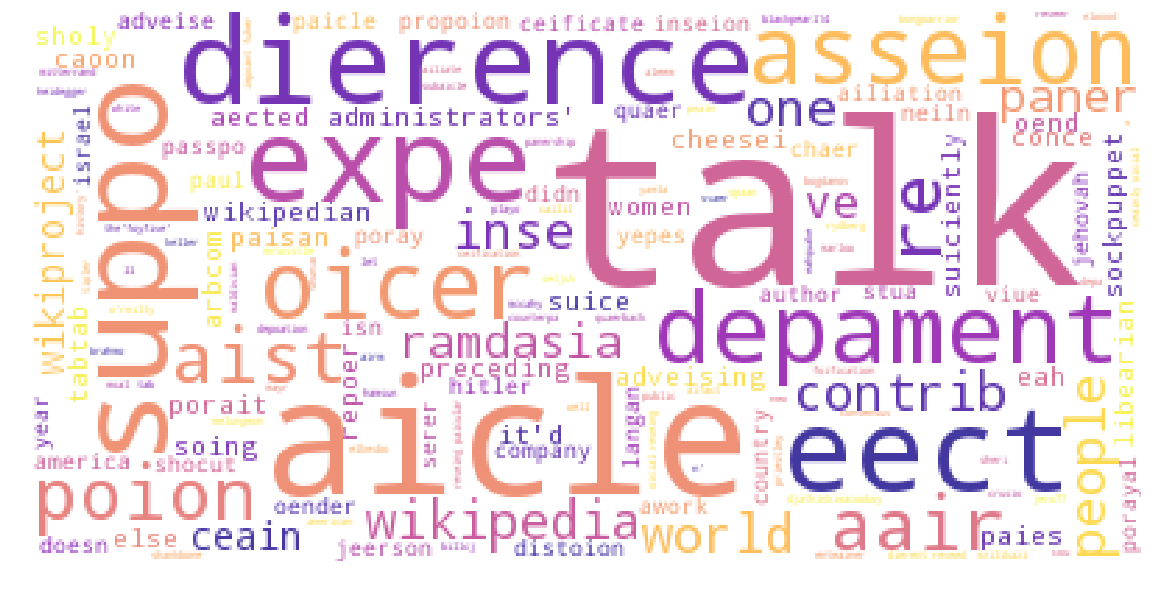

In [132]:
# It's evident that online comments would be strife with misspellings
wc_stopwords=set(STOPWORDS)
wc_misspelling= WordCloud(background_color="white",max_words=2000,stopwords=wc_stopwords)
wc_misspelling.generate(" ".join(unknown_words))
plt.figure(figsize=(20,20))
plt.axis("off")
plt.imshow(wc_misspelling.recolor(colormap= 'plasma' , random_state=12), alpha=0.8)
plt.show()

In [138]:
# Creating Embedding Matrix with spell check
spellchecker = enchant.Dict("en_US")
unknown_words2=[]
corrected_words={}

word_index_50 = tokenizer_50.word_index
nb_words_50 = min(max_features_50, len(word_index_50))
embedding_matrix_50 = np.random.normal(emb_mean_glove, emb_std_glove, (nb_words_50, embed_size_50))

for word, i in word_index_50.items():
    if i >= max_features_50:
        continue
    embedding_vector = embeddings_index_glove.get(word)
    if embedding_vector is not None:
        embedding_matrix_50[i] = embedding_vector
    else:
        if(len(spellchecker.suggest(word))>0):
            embedding_vector = embeddings_index_glove.get(spellchecker.suggest(word)[0])
            if embedding_vector is not None:
                embedding_matrix_50[i] = embedding_vector
                corrected_words[word]=spellchecker.suggest(word)[0]
            else:
                unknown_words2.append(word)

word_index_300 = tokenizer_300.word_index
nb_words_300 = min(max_features_300, len(word_index_300))
embedding_matrix_300 = np.random.normal(emb_mean_fasttext, emb_std_fasttext, (nb_words_300, embed_size_300))

for word, i in word_index_300.items():
    if i >= max_features_300:
        continue
    embedding_vector = embeddings_index_fasttext.get(word)
    if embedding_vector is not None:
        embedding_matrix_300[i] = embedding_vector
    else:
        if(len(spellchecker.suggest(word))>0):
            embedding_vector = embeddings_index_fasttext.get(spellchecker.suggest(word)[0])
            if embedding_vector is not None:
                embedding_matrix_300[i] = embedding_vector
                corrected_words[word]=spellchecker.suggest(word)[0]
            else:
                unknown_words2.append(word)

In [337]:
#We sample a few spelling replacements to see if they were correct
random_ix=[]
before_spell = list(corrected_words.keys())
after_spell = list(corrected_words.values())
print("A sample of a few corrections: \n")
for x in range (0, 5):
    random_ix.append(random.randint(0, len(corrected_words)))

for i in random_ix:
    print(before_spell[i] +" --> "+after_spell[i])

A sample of a few corrections: 

unfounate --> unfortunate
alstair --> Alastair
viually --> visually
tolkien's --> Tolkien
jeery --> jeer


### Section 3 : Data Analysis
1. Category wordclouds
2. Sentence Length analysis for labels
3. Emoticon Analysis for labels
4. Label Correlations

In [13]:
#Trainng Sentence Length Analysis for Labels
sen_length_label = {}
sen_count_label = {}
sen_length_label["Toxic"]=0
sen_count_label["Toxic"]=0
sen_length_label["Insult"]=0
sen_count_label["Insult"]=0
sen_length_label["Hate"]=0
sen_count_label["Hate"]=0
sen_length_label["Threat"]=0
sen_count_label["Threat"]=0
sen_length_label["Obscene"]=0
sen_count_label["Obscene"]=0
sen_length_label["Neutral"]=0
sen_count_label["Neutral"]=0
for ix,sen in enumerate(sentences_train):
    word_count = len(sen.split(" "))
    if(y_train[ix][0]==1):
        sen_length_label["Toxic"]+=word_count
        sen_count_label["Toxic"]+=1
    if(y_train[ix][1]==1):
        sen_length_label["Insult"]+=word_count
        sen_count_label["Insult"]+=1
    if(y_train[ix][2]==1):
        sen_length_label["Hate"]+=word_count
        sen_count_label["Hate"]+=1
    if(y_train[ix][3]==1):
        sen_length_label["Threat"]+=word_count
        sen_count_label["Threat"]+=1
    if(y_train[ix][4]==1):
        sen_length_label["Obscene"]+=word_count
        sen_count_label["Obscene"]+=1
    if(y_train[ix][5]==1):
        sen_length_label["Neutral"]+=word_count
        sen_count_label["Neutral"]+=1

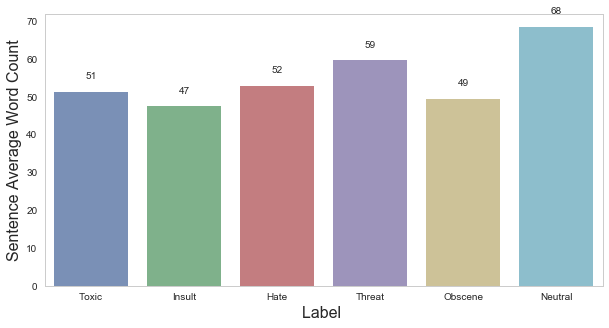

In [14]:
sen_length_label["Toxic"]/=sen_count_label["Toxic"]
sen_length_label["Insult"]/=sen_count_label["Insult"]
sen_length_label["Hate"]/=sen_count_label["Hate"]
sen_length_label["Threat"]/=sen_count_label["Threat"]
sen_length_label["Obscene"]/=sen_count_label["Obscene"]
sen_length_label["Neutral"]/=sen_count_label["Neutral"]

plt.figure(figsize=(10,5))
ax= sns.barplot(["Toxic","Insult","Hate","Threat","Obscene","Neutral"], [sen_length_label["Toxic"],sen_length_label["Insult"],sen_length_label["Hate"],sen_length_label["Threat"],sen_length_label["Obscene"],sen_length_label["Neutral"]], alpha=0.8)
plt.ylabel('Sentence Average Word Count', fontsize=14)
plt.xlabel('Label ', fontsize=14)
rects = ax.patches
labels = [sen_length_label["Toxic"],sen_length_label["Insult"],sen_length_label["Hate"],sen_length_label["Threat"],sen_length_label["Obscene"],sen_length_label["Neutral"]]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 3, int(label), ha='center', va='bottom')
ax.grid(False)

plt.show()
#It can be inferred that abusive sentences are generally shorted

In [39]:
#Frequent Emojis in labels
emoji_count_label={}
emoji_count_label["Toxic"]=[]
emoji_count_label["Insult"]=[]
emoji_count_label["Hate"]=[]
emoji_count_label["Threat"]=[]
emoji_count_label["Obscene"]=[]
emoji_count_label["Neutral"]=[]


for ix,sen in enumerate(sentences_train):
    emojis = emoji_regex.findall(sen)
    if(y_train[ix][0]==1):
        emoji_count_label["Toxic"].extend(emojis)
    if(y_train[ix][1]==1):
        emoji_count_label["Insult"].extend(emojis)
    if(y_train[ix][2]==1):
        emoji_count_label["Hate"].extend(emojis)
    if(y_train[ix][3]==1):
        emoji_count_label["Threat"].extend(emojis)
    if(y_train[ix][4]==1):
        emoji_count_label["Obscene"].extend(emojis)
    if(y_train[ix][5]==1):
        emoji_count_label["Neutral"].extend(emojis)    



In [88]:
print("Most Frequent Emojis \n")
frequent_emoji={}
for label in ["Toxic","Insult","Hate","Obscene","Neutral"]:
    unique, counts = np.unique(emoji_count_label[label] , return_counts=True)
    z = [x for _,x in sorted(zip(counts,unique))][-2:]
    frequent_emoji[label]=z
    print(label + " : "+ " ".join(str(x) for x in z))

#It can be inferred that abusive comments  have frequent occurrences of 😠 emoticon

Most Frequent Emojis 

Toxic : 😠 😊
Insult : 😠 😊
Hate : 😊 😔
Obscene : 😠 😊
Neutral : 😔 😊


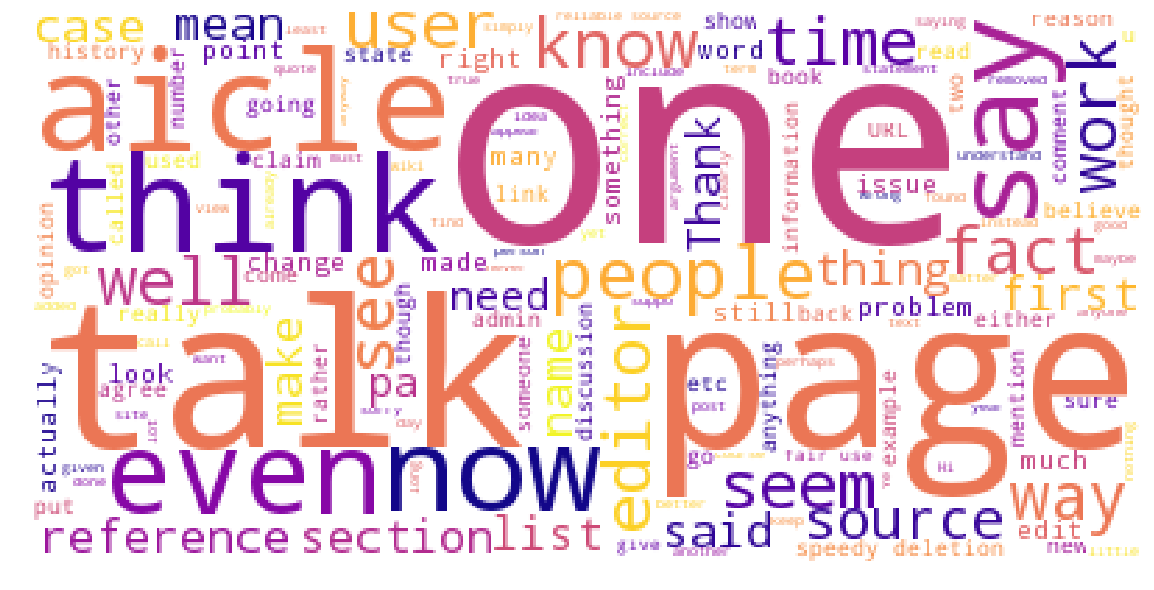

In [47]:
#Word Cloud for Neutral sentences
neutrals=train_dataset[train_dataset.neutral==1]
wc_neutral_text=neutrals.sentence.values
wc_neutral= WordCloud(background_color="white",max_words=2000,stopwords=wc_stopwords)
wc_neutral.generate(" ".join(wc_neutral_text))
plt.figure(figsize=(20,20))
plt.axis("off")
plt.imshow(wc_neutral.recolor(colormap= 'plasma' , random_state=12), alpha=1)
plt.show()

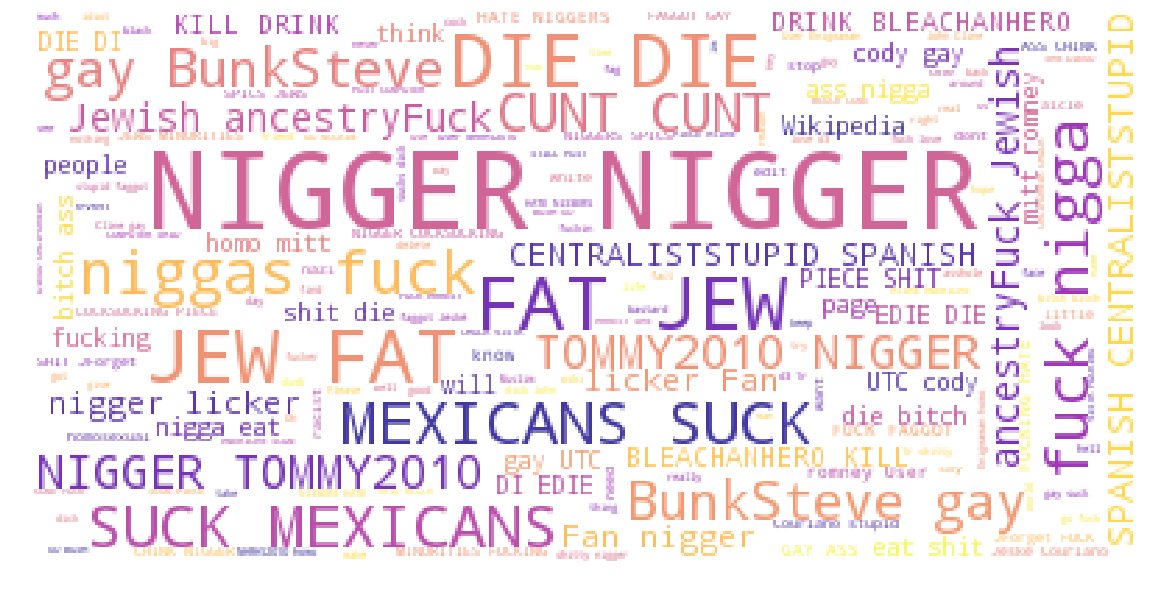

In [51]:
#Word Cloud for Toxic sentences
toxics=train_dataset[train_dataset.hate==1]
wc_toxic_text=toxics.sentence.values
wc_toxic= WordCloud(background_color="white",max_words=2000,stopwords=wc_stopwords)
wc_toxic.generate(" ".join(wc_toxic_text))
plt.figure(figsize=(20,20))
plt.axis("off")
plt.imshow(wc_toxic.recolor(colormap= 'plasma' , random_state=12), alpha=0.8)
plt.show()

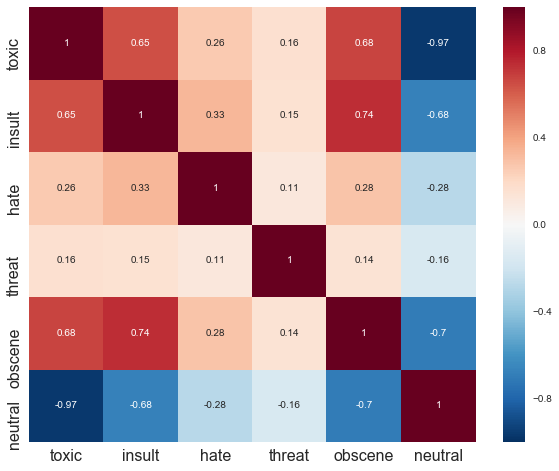

In [318]:
#Correlation Analysis
#Sentences may have have been tagged with multible labels owing to the similarity of labels
corr_df=train_dataset.iloc[:,1:]
corr=corr_df.corr()
fig=plt.figure(figsize=(10,8))
ax=sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)
ax.tick_params(labelsize=16)

#Looks like most Toxic sentences are often marked together with Insult and Obscene tags

### Section 4 : Training Classification Models
1. Bidirectional LSTM Models
    * 50 Dimensional GloVe Embeddings
    * 300 Dimensional FastText Embeddings
    * Dropout variations
2. Logistic Regression Classifier
3. Bidirectional GRU + Conv Models
    * 50 Dimensional GloVe Embeddings
    * 300 Dimensional FastText Embeddings
    * Dropout variations

In [170]:
class LossHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.batch = []


    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.batch.append(logs.get('batch'))
        #print(logs)

In [258]:
#Calculates Test dataset accuracy and displays confusion matrix
def testAccuracy(model,test,name,y_pre=None):
    if y_pre==None:
        y_pre = model.predict([test], batch_size=1024, verbose=0)
    tt=y_pre.argmax(axis=1)
    list_classes=['toxic','insult','hate','threat','obscene','neutral']
    confusion=np.zeros((len(list_classes),len(list_classes)))
    y_test=test_dataset[list_classes].values
    count = 0
    true =0
    ind=0
    
    for t in tt:
        match=False
        
                
        if y_test[ind][t]==1:
            true=true+1
            match=True
        if match:
            for i in np.arange(6):
                if y_test[ind][i]==1:
                    confusion[i][i]+=1
        else:
            for i in np.arange(5,-1,-1):
                if y_test[ind][i]==1:
                    confusion[t][i]+=1
                
        count=count+1
        ind=ind+1
    
    acc = true/count*100.0
    print("Test Accuracy of "+name+" : "+str(acc)+" %")
    return confusion
    

In [191]:
#Plots Training Accracy ,Loss
def plotTrainingHistory(history):
    plt.subplot(2,1,1)
    plt.plot(history.batch[:200],history.acc[:200])
    plt.ylabel('Training Accuracy %')
    plt.xlabel('Batch Number')
    plt.legend(['Training'], loc='lower right')
    plt.grid(color='r', linestyle=':', linewidth=0.3)

    plt.subplot(2,1,2)
    plt.plot(history.batch[:200],history.losses[:200],color='green')
    plt.ylabel('Loss')
    plt.xlabel('Batch Number')
    plt.legend(['Loss'], loc='upper right')
    plt.grid(color='r', linestyle=':', linewidth=0.3)

    plt.show()

In [256]:
def plotConfusion(cm,normalize,name='Confusion Matrix'):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig=plt.figure(figsize=(10,8))
    ax=sns.heatmap(cm,
            xticklabels=list_classes,
            yticklabels=list_classes, annot=True)
    ax.tick_params(labelsize=16)

### Section 4.1 : Bidirectional LSTM Models
    * Model 1 : 50 Dimensional GloVe Embeddings
    * Model 2 : 300 Dimensional FastText Embeddings
    * Model 3 : Dropout variations

In [171]:
#Defining a Bidirectional LSTM Model in Keras
#Model 1 (Bi-LSTM Baseline): 50 Dim Glove Vectors , 0.1 dropout
history_1 = LossHistory()

inp = Input(shape=(maxlen_50,))
x = Embedding(max_features_50, embed_size_50, weights=[embedding_matrix_50])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model_1 = Model(inputs=inp, outputs=x)
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [172]:
model_1.fit(x_train_50, y_train, batch_size=512, epochs=2, validation_split=0.1,callbacks=[history_1])

Train on 116142 samples, validate on 12905 samples
Epoch 1/2
116142/116142 [==============================] - 364s 3ms/step - loss: 0.1813 - acc: 0.9392 - val_loss: 0.0826 - val_acc: 0.9709
Epoch 2/2
116142/116142 [==============================] - 373s 3ms/step - loss: 0.0783 - acc: 0.9733 - val_loss: 0.0709 - val_acc: 0.9757


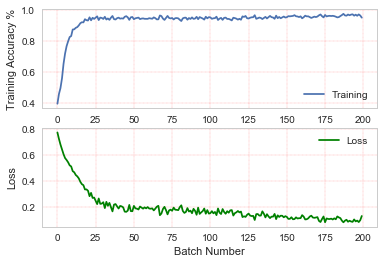

In [192]:
plotTrainingHistory(history_1)

In [175]:
#Defining a Bidirectional LSTM Model in Keras
#Model 2 : 300 Dim FastText Vectors , 0.1 dropout
history_2 = LossHistory()

inp = Input(shape=(maxlen_300,))
x = Embedding(max_features_300, embed_size_300, weights=[embedding_matrix_300])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model_2 = Model(inputs=inp, outputs=x)
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [176]:
model_2.fit(x_train_300, y_train, batch_size=512, epochs=2, validation_split=0.1,callbacks=[history_2])

Train on 116142 samples, validate on 12905 samples
Epoch 1/2
116142/116142 [==============================] - 967s 8ms/step - loss: 0.1415 - acc: 0.9586 - val_loss: 0.0640 - val_acc: 0.9761
Epoch 2/2
116142/116142 [==============================] - 929s 8ms/step - loss: 0.0590 - acc: 0.9784 - val_loss: 0.0613 - val_acc: 0.9773


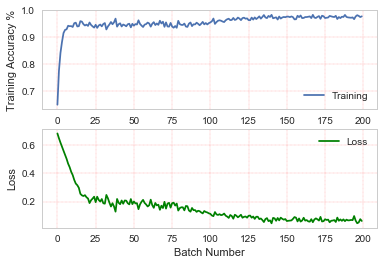

In [193]:
plotTrainingHistory(history_2)

In [195]:
#It's seen that the model 2 with 300 dimensional FastText embedding gets better Training Acc
#We proceed to experiment further by increasing the dropout to 0.2 for this model

#Model 3 : 300 Dim FastText Vectors , 0.2 dropout
history_3 = LossHistory()

inp = Input(shape=(maxlen_300,))
x = Embedding(max_features_300, embed_size_300, weights=[embedding_matrix_300])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(6, activation="sigmoid")(x)
model_3 = Model(inputs=inp, outputs=x)
model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [196]:
model_3.fit(x_train_300, y_train, batch_size=512, epochs=2, validation_split=0.1,callbacks=[history_3])

Train on 116142 samples, validate on 12905 samples
Epoch 1/2
116142/116142 [==============================] - 904s 8ms/step - loss: 0.1853 - acc: 0.9376 - val_loss: 0.0663 - val_acc: 0.9752
Epoch 2/2
116142/116142 [==============================] - 864s 7ms/step - loss: 0.0652 - acc: 0.9768 - val_loss: 0.0610 - val_acc: 0.9768


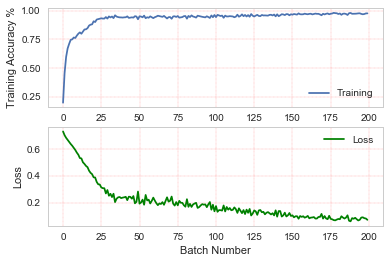

In [197]:
plotTrainingHistory(history_3)

In [198]:
#It's seen that the model 2 with 300 dimensional FastText embedding gets better Training Acc
#We proceed to experiment further by increasing the dropout to 0.2 for this model

#Model 4 : 300 Dim FastText Vectors , 0.05 dropout
history_4 = LossHistory()

inp = Input(shape=(maxlen_300,))
x = Embedding(max_features_300, embed_size_300, weights=[embedding_matrix_300])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.05, recurrent_dropout=0.05))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.05)(x)
x = Dense(6, activation="sigmoid")(x)
model_4 = Model(inputs=inp, outputs=x)
model_4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [199]:
model_4.fit(x_train_300, y_train, batch_size=512, epochs=2, validation_split=0.1,callbacks=[history_4])

Train on 116142 samples, validate on 12905 samples
Epoch 1/2
116142/116142 [==============================] - 959s 8ms/step - loss: 0.1527 - acc: 0.9502 - val_loss: 0.0644 - val_acc: 0.9758
Epoch 2/2
116142/116142 [==============================] - 966s 8ms/step - loss: 0.0587 - acc: 0.9785 - val_loss: 0.0614 - val_acc: 0.9771


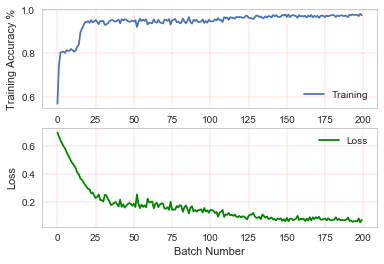

In [200]:
plotTrainingHistory(history_4)

In [259]:
# Checking Test Accuracy for these 4 BiLSTM Models
c1=testAccuracy(model_1,x_test_50,"Model 1",None)
c2=testAccuracy(model_2,x_test_300,"Model 2",None)
c3=testAccuracy(model_3,x_test_300,"Model 3",None)
c4=testAccuracy(model_4,x_test_300,"Model 4",None)

Test Accuracy of Model 1 : 86.6237546784313 %
Test Accuracy of Model 2 : 88.79527003815069 %
Test Accuracy of Model 3 : 88.52767280814363 %
Test Accuracy of Model 4 : 88.63977435044389 %


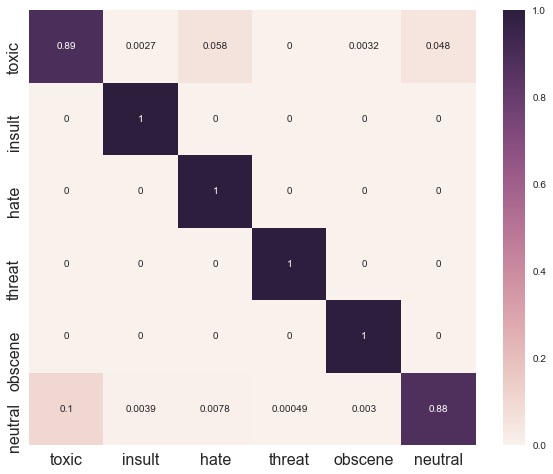

In [264]:
#Model 2 is the best model for a Bi-LSTM structure with 300 D FastText embeddings and 0.1 dropout
#Plotting confusion matrix
plotConfusion(c2,True,name='Confusion Matrix')

### Section 4.2 : Logistic Regression Classifier
    * Generate word-level and character-level features

In [223]:
#Generating Word-level and Character-level features using Scikit-learn TF-IDF Vectorizer
#n-gram range for characters-level features is (2,6) and word-level features is (1,1)

train_text = train_dataset['sentence']
test_text = test_dataset['sentence']
all_text = pd.concat([train_text, test_text])

word_vectorizer = TfidfVectorizer(
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000,
    sublinear_tf=True,
    strip_accents='unicode')
word_vectorizer.fit(all_text)

train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

char_vectorizer = TfidfVectorizer(
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=50000,
    sublinear_tf=True,
    strip_accents='unicode')
char_vectorizer.fit(all_text)

train_char_features = char_vectorizer.transform(train_text)
test_char_features = char_vectorizer.transform(test_text)

train_features = hstack([train_char_features, train_word_features])
test_features = hstack([test_char_features, test_word_features])

In [224]:
scores = []
list_classes=['toxic','insult','hate','threat','obscene','neutral']
regression_result = {}
for label in list_classes:
    train_label = train_dataset[label]
    classifier = LogisticRegression(C=0.1, solver='sag')
    cv_score = np.mean(cross_val_score(classifier, train_features, train_label, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print('Cross-Validation score for class {} is {}'.format(label, cv_score))
    classifier.fit(train_features, train_label)
    regression_result[label] = classifier.predict_proba(test_features)[:, 1]

Cross-Validation score for class toxic is 0.9677865582293559
Cross-Validation score for class insult is 0.9766067979951961
Cross-Validation score for class hate is 0.9713355142052092
Cross-Validation score for class threat is 0.9827902139936299
Cross-Validation score for class obscene is 0.9832045244320838
Cross-Validation score for class neutral is 0.967310435692957


Test Accuracy of Logistic Regression : 67.9606559748314 %


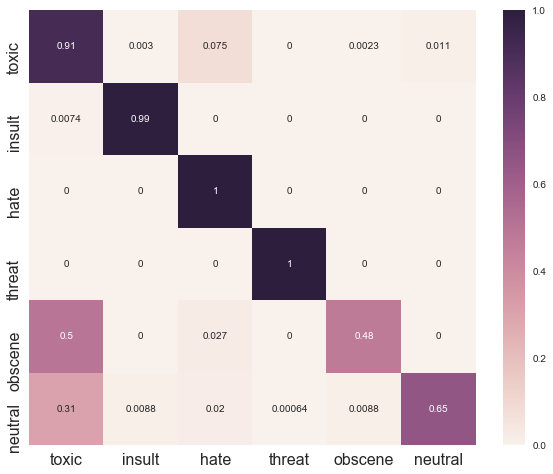

In [261]:
#Checking Test Accuracy of logistic regression
#Creating a Confusion Matrix
aa=pd.DataFrame.from_dict(regression_result)
y_pre = aa[list_classes].values
c5=testAccuracy(None,None,"Logistic Regression",y_pre)
plotConfusion(c5,True,name='Confusion Matrix')

#It can be seen that the model performs poorly in classifying Neutral and Obscene labels
#Moreover the test accuract is ~68%

### Section 4.3 : Bidirectional GRU + CNN Models
    * Model 1 : 50 Dimensional GloVe Embeddings
    * Model 2 : 300 Dimensional FastText Embeddings
    * Model 3 : Dropout variations

In [271]:
#Model 6: BiGRU + CNN with 50 dim GloVe word embeddings

history_6 = LossHistory()
inp = Input(shape=(maxlen_50,))
x = Embedding(max_features_50, embed_size_50, weights=[embedding_matrix_50])(inp)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x)
x = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool])
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model_6 = Model(inputs=inp, outputs=x)
model_6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [272]:
model_6.fit(x_train_50, y_train, batch_size=512, epochs=2, validation_split=0.1,callbacks=[history_6])

Train on 116142 samples, validate on 12905 samples
Epoch 1/2
116142/116142 [==============================] - 836s 7ms/step - loss: 0.1243 - acc: 0.9609 - val_loss: 0.0770 - val_acc: 0.9733
Epoch 2/2
116142/116142 [==============================] - 806s 7ms/step - loss: 0.0794 - acc: 0.9730 - val_loss: 0.0694 - val_acc: 0.9757


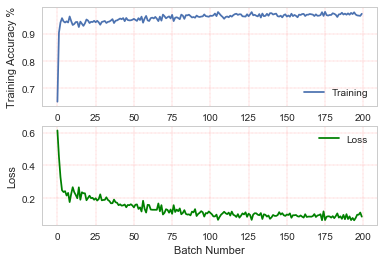

In [273]:
plotTrainingHistory(history_6)

In [274]:
#Model 7: BiGRU + CNN with 300 dim FastText word embeddings
history_7 = LossHistory()
inp = Input(shape=(maxlen_300,))
x = Embedding(max_features_300, embed_size_300, weights=[embedding_matrix_300])(inp)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x)
x = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool])
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model_7 = Model(inputs=inp, outputs=x)
model_7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [275]:
model_7.fit(x_train_300, y_train, batch_size=512, epochs=2, validation_split=0.1,callbacks=[history_7])

Train on 116142 samples, validate on 12905 samples
Epoch 1/2
116142/116142 [==============================] - 1581s 14ms/step - loss: 0.1140 - acc: 0.9623 - val_loss: 0.0608 - val_acc: 0.9774
Epoch 2/2
116142/116142 [==============================] - 1627s 14ms/step - loss: 0.0584 - acc: 0.9784 - val_loss: 0.0602 - val_acc: 0.9779


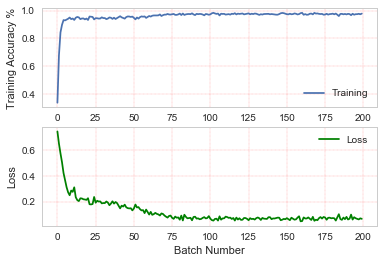

In [276]:
plotTrainingHistory(history_7)

In [277]:
#300 Dimension FastText embeddings have better training accuracy
# Model 8 : In the Bi-GRU+CNN Model with FastText embeddings in model 7, dropout and a dense layer is removed

history_8 = LossHistory()
inp = Input(shape=(maxlen_300,))
x = Embedding(max_features_300, embed_size_300, weights=[embedding_matrix_300])(inp)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x)
x = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool])
x = Dense(6, activation="sigmoid")(x)
model_8 = Model(inputs=inp, outputs=x)
model_8.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [278]:
model_8.fit(x_train_300, y_train, batch_size=512, epochs=2, validation_split=0.1,callbacks=[history_8])

Train on 116142 samples, validate on 12905 samples
Epoch 1/2
116142/116142 [==============================] - 1581s 14ms/step - loss: 0.1004 - acc: 0.9673 - val_loss: 0.0609 - val_acc: 0.9771
Epoch 2/2
116142/116142 [==============================] - 1621s 14ms/step - loss: 0.0553 - acc: 0.9793 - val_loss: 0.0587 - val_acc: 0.9782


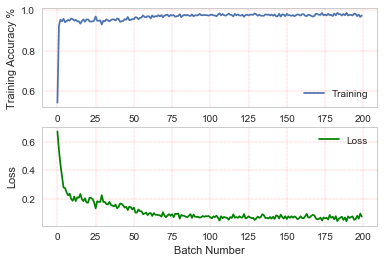

In [280]:
plotTrainingHistory(history_8)

In [279]:
# Checking Test Accuracy for these 3 BiGRU Models
c6=testAccuracy(model_6,x_test_50,"Model 6",None)
c7=testAccuracy(model_7,x_test_300,"Model 7",None)
c8=testAccuracy(model_8,x_test_300,"Model 8",None)

Test Accuracy of Model 6 : 86.75393711465095 %
Test Accuracy of Model 7 : 87.88399298461316 %
Test Accuracy of Model 8 : 88.96342235160107 %


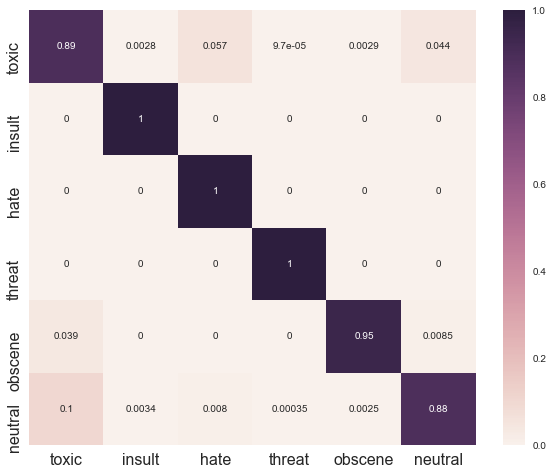

In [281]:
plotConfusion(c8,True,name='Confusion Matrix')

## Section 5 : Model Ensemble
* Collective prediction through model voting
* Use BiLSTM model 2 with dropout 0.1, BiGRU model 8 with no dropout and linear regression model together to vote for the predicted label

In [316]:
def vote(L):
  SL = sorted((x, i) for i, x in enumerate(L))
  groups = itertools.groupby(SL, key=operator.itemgetter(0))
  def _auxfun(g):
    item, iterable = g
    count = 0
    min_index = len(L)
    for _, where in iterable:
      count += 1
      min_index = min(min_index, where)
    return count, -min_index
  return max(groups, key=_auxfun)[0]

def testAccuracyEnsemble(y_pre_bilstm,y_pre_bigru,y_pre_logreg):
    
    list_classes=['toxic','insult','hate','threat','obscene','neutral']

    y_pre_bilstm=y_pre_bilstm.argmax(axis=1)
    y_pre_bigru=y_pre_bigru.argmax(axis=1)
    y_pre_logreg=y_pre_logreg.argmax(axis=1)
    
    confusion=np.zeros((len(list_classes),len(list_classes)))
    y_test=test_dataset[list_classes].values
    count = 0
    true =0
    ind=0
    
    for j in range(len(y_pre_bilstm)):
        match=False
        t = vote([y_pre_bigru[j],y_pre_bilstm[j],y_pre_logreg[j],y_pre_logreg[j]])
                
        if y_test[ind][t]==1:
            true=true+1
            match=True
        if match:
            for i in np.arange(6):
                if y_test[ind][i]==1:
                    confusion[i][i]+=1
        else:
            for i in np.arange(5,-1,-1):
                if y_test[ind][i]==1:
                    confusion[t][i]+=1
                
        count=count+1
        ind=ind+1
    
    acc = true/count*100.0
    print("Test Accuracy of Ensemble : "+str(acc)+" %")
    return confusion
    

In [306]:
y_pre_bilstm = model_2.predict([x_test_300], batch_size=1024, verbose=0)
y_pre_bigru = model_8.predict([x_test_300], batch_size=1024, verbose=0)
y_pre_logreg = aa[list_classes].values

Test Accuracy of Ensemble : 88.7591082503119 %


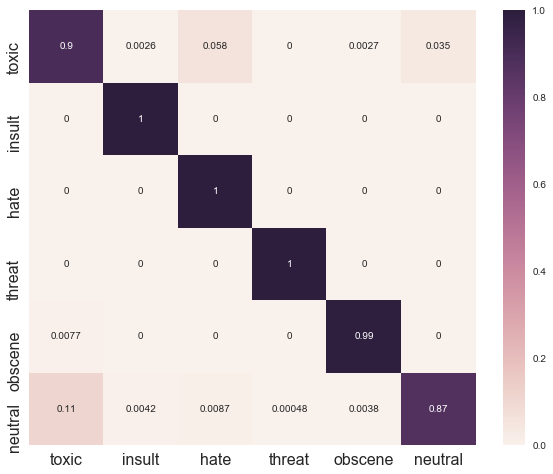

In [317]:
ce=testAccuracyEnsemble(y_pre_bilstm,y_pre_bigru,y_pre_logreg)
plotConfusion(ce,True)

### Conclusion
* A Bi-GRU + Convolution Network performs marginally better than the ensemble
* Logistic Regression model classifies neutral sentences as abusive
* Neural Network models outperform the Log Regression classifier